In [1]:
import pickle
from  test_city import calculate
from multiprocessing import Pool

In [35]:
# city_id: R13470549, Graph with 729 nodes and 1068 edges
# city_id: R4676636, Graph with 3349 nodes and 4519 edges
# city_id: R6564910, Graph with 5485 nodes and 7656 edges
# city_id: R71525, Graph with 9517 nodes and 14837 edges
# city_id: R435514, Graph with 21681 nodes and 30128 edges
# city_id: R2555133, Graph with 17793 nodes and 26845 edges
# city_id: R17140517, Graph with 23897 nodes and 35606 edges
# city_id: R62422, Graph with 28088 nodes and 42098 edges
# city_id: R41485, Graph with 43510 nodes and 60563 edges
# city_id: R207359, Graph with 49514 nodes and 72143 edges

In [2]:
total = 6
points_number = 5000

print('THREADS:', total)
print('POINTS:', points_number)

cities = {
    'ASHA': 'R13470549',
    'KRG': 'R4676636',
    # 'EKB': 'R6564910',
    # 'BARCELONA': 'R347950',
    'PARIS': 'R71525',
    'Prague': 'R435514',
    # 'MSK': 'R2555133',
    # 'SBP': 'R337422',
    # 'SINGAPORE': 'R17140517',
    # 'BERLIN': 'R62422',
    # 'ROME': 'R41485',
    # 'LA': 'R207359',
    # 'DUBAI': 'R4479752',
    # 'RIO': 'R2697338',
    # 'DELHI': 'R1942586',
    # 'KAIR': 'R5466227'
}
total_len = len(cities)
l = list(cities.items())
data = [[l[i: total_len: total],points_number, i + 1, total] for i in range(total)]
# print(data)
with Pool(total) as p:
    p.map(calculate, data)

THREADS: 6
POINTS: 5000


Scatter plot saved to data/img\scatter_speed_up_vs_alpha_ASHA.png


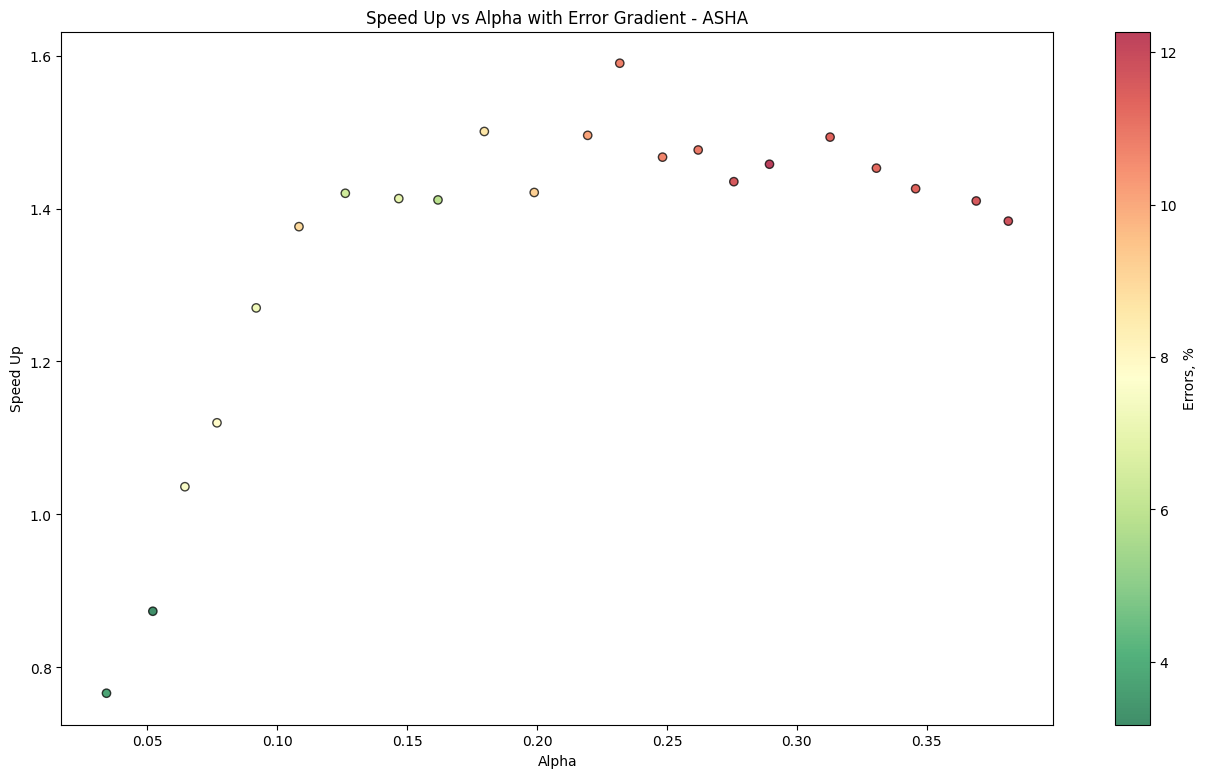

Scatter plot saved to data/img\scatter_speed_up_vs_alpha_KRG.png


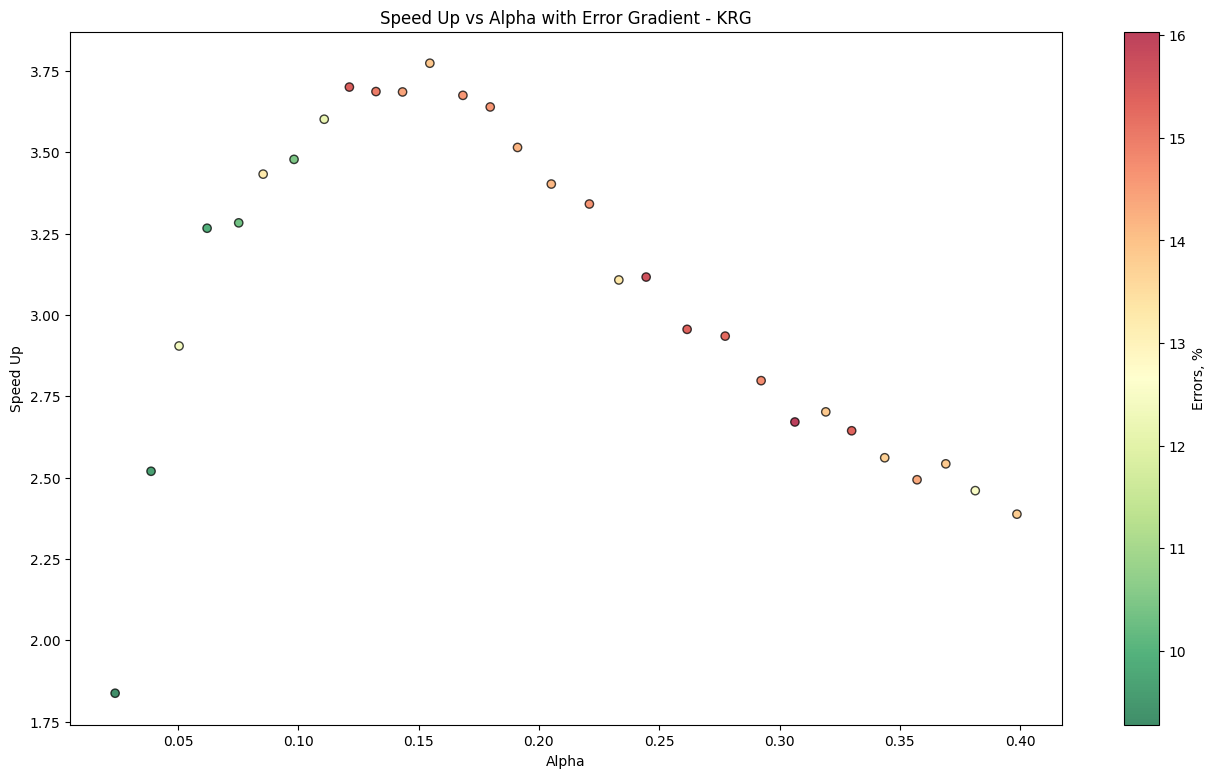

Scatter plot saved to data/img\scatter_speed_up_vs_alpha_PARIS.png


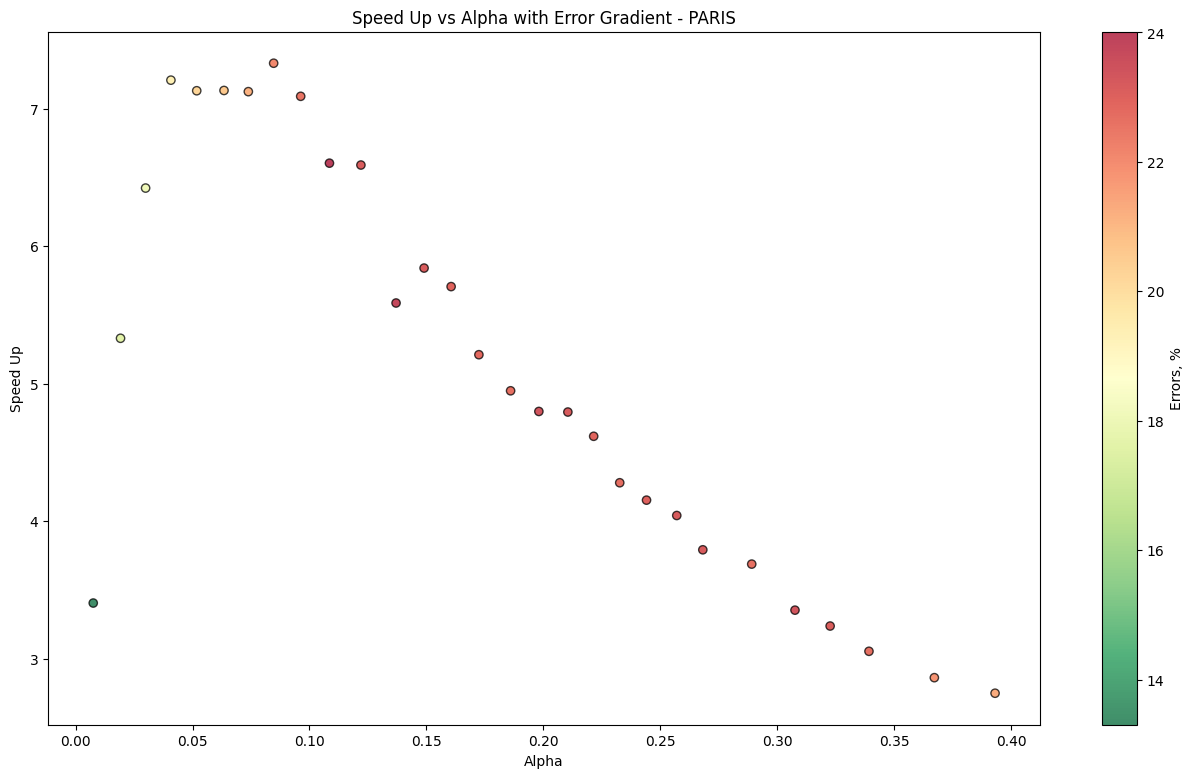

Scatter plot saved to data/img\scatter_speed_up_vs_alpha_Prague.png


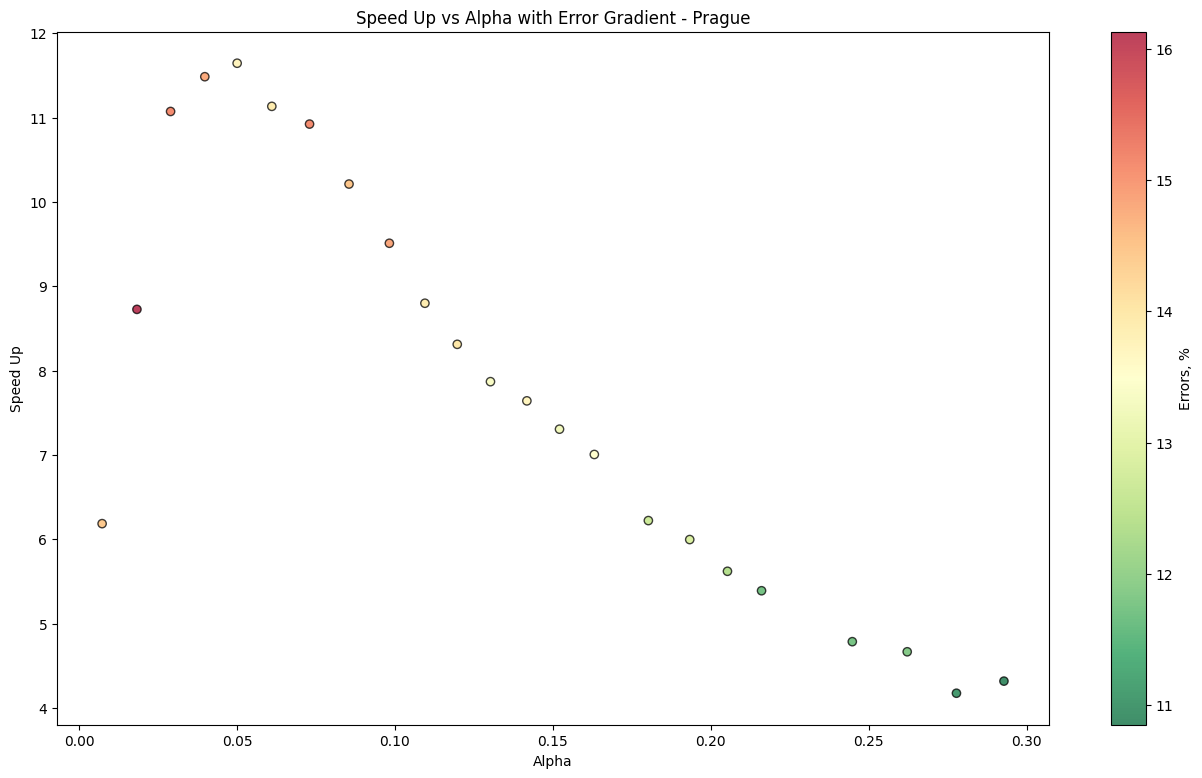

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import os

def scatter_visualisation(speed_up, alphas, errors, name='city', output_dir="data/img", show=False):
    plt.figure(figsize=(16, 9))
    
    # Создаем scatter plot
    scatter = plt.scatter(alphas, speed_up, c=errors, cmap='RdYlGn_r', edgecolor='k', alpha=0.75)
    plt.colorbar(scatter, label='Errors, %')
    
    # Устанавливаем подписи для осей
    plt.ylabel('Speed Up')
    plt.xlabel('Alpha')
    plt.title(f'Speed Up vs Alpha with Error Gradient - {name}')
    
    # Создание папки, если она не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Запись PNG
    file_path = os.path.join(output_dir, f"scatter_speed_up_vs_alpha_{name}.png")
    plt.savefig(file_path, dpi=600)
    
    print(f"Scatter plot saved to {file_path}")
    if show:
        plt.show()
for n in ['ASHA', 'KRG', 'PARIS', 'Prague']:
    with open(f'clusters_results/2024_06_26/{n}.pkl', 'rb') as f:
        data = pickle.load(f)
        # Извлекаем значения speed_up, alpha и errors в отдельные списки
    speed_up = [results.speed_up[0] for results in data.points_results]
    alphas = [results.alpha for results in data.points_results]
    errors = [np.mean(results.errors) * 100 for results in data.points_results]  # усредняем ошибки и масштабируем

    # Вызываем функцию для создания и сохранения scatter plot
    scatter_visualisation(speed_up, alphas, errors, data.name, show=True)

Boxplot saved to data/img\boxplot_errors_ASHA.png


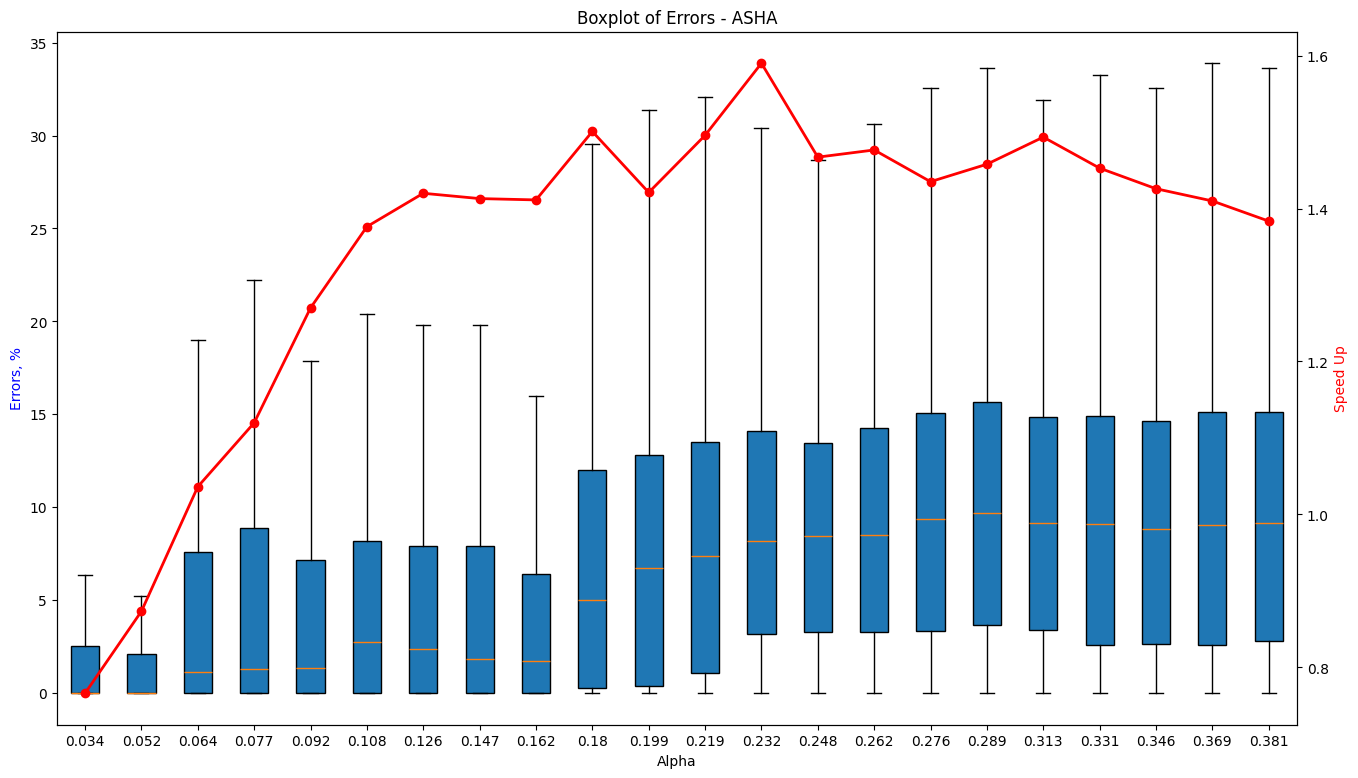

Boxplot saved to data/img\boxplot_errors_KRG.png


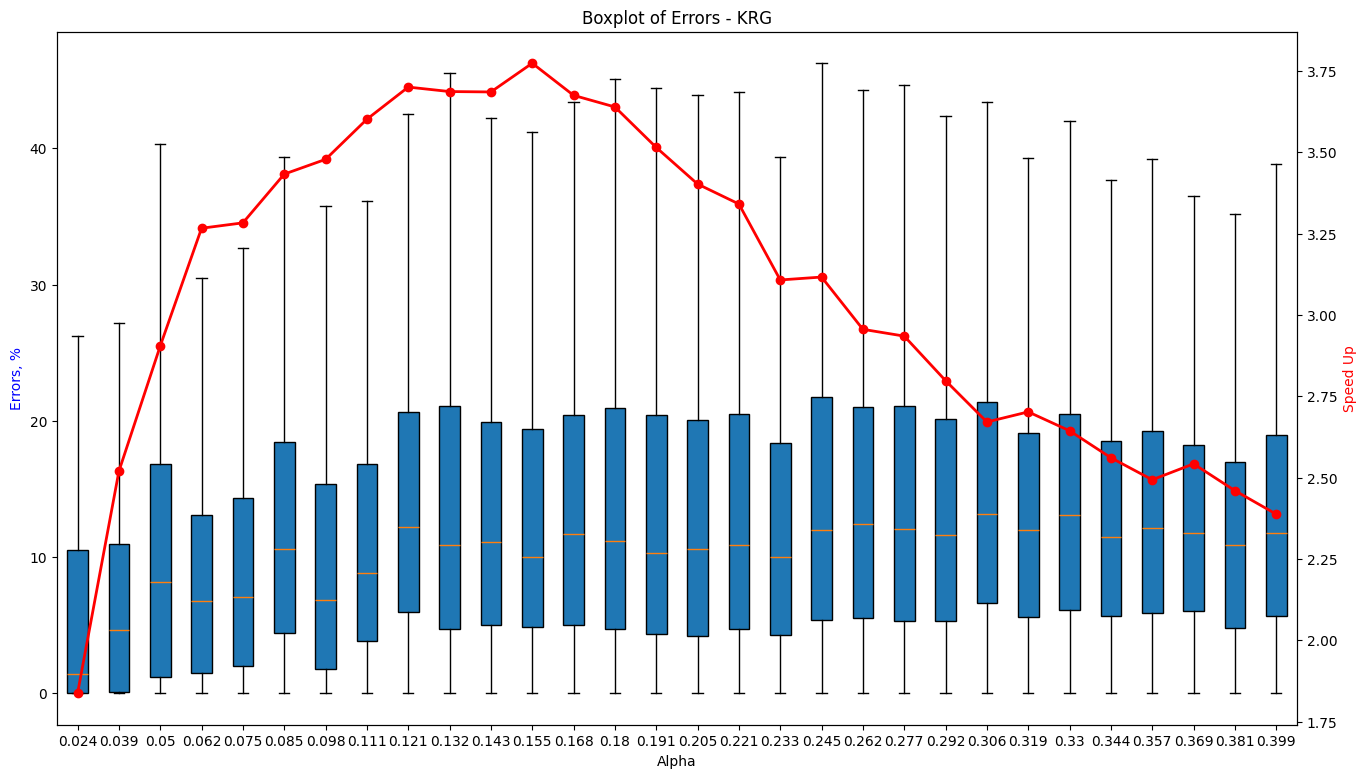

Boxplot saved to data/img\boxplot_errors_PARIS.png


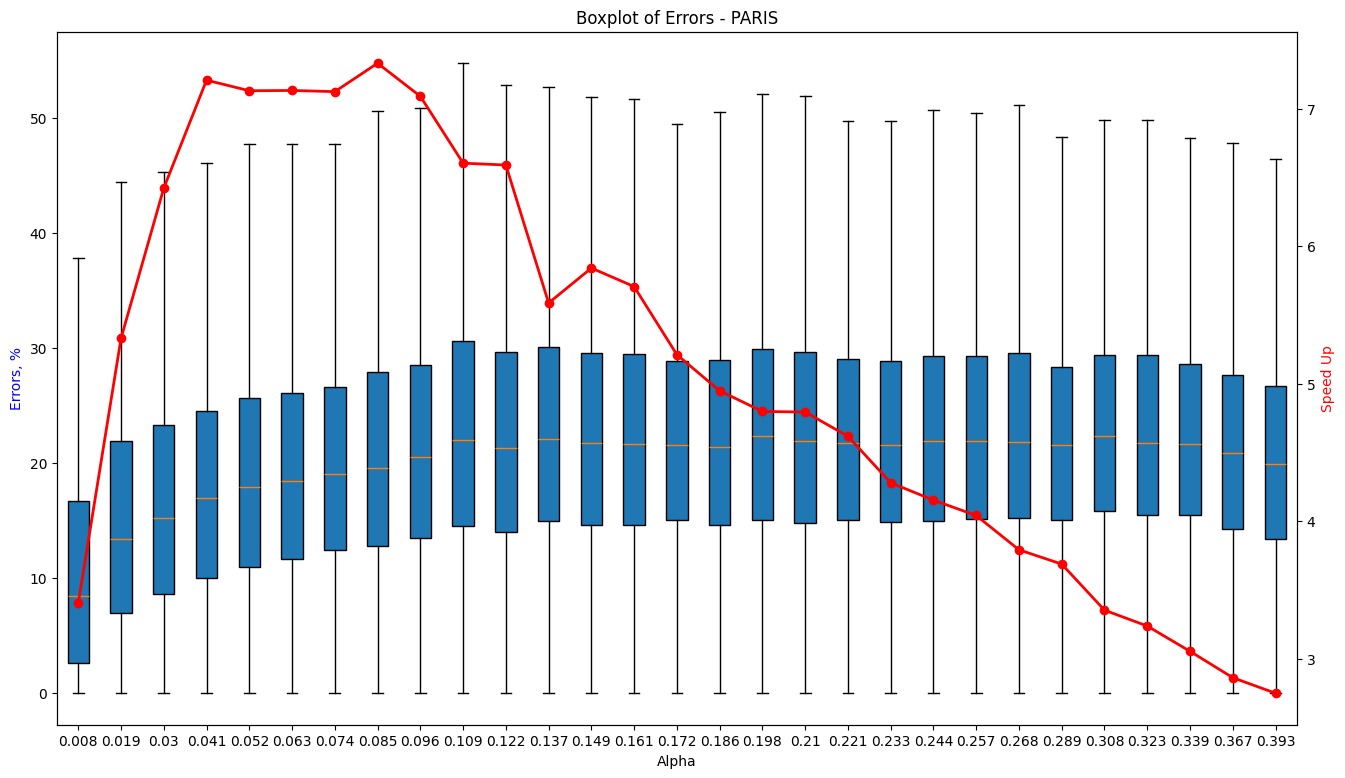

Boxplot saved to data/img\boxplot_errors_Prague.png


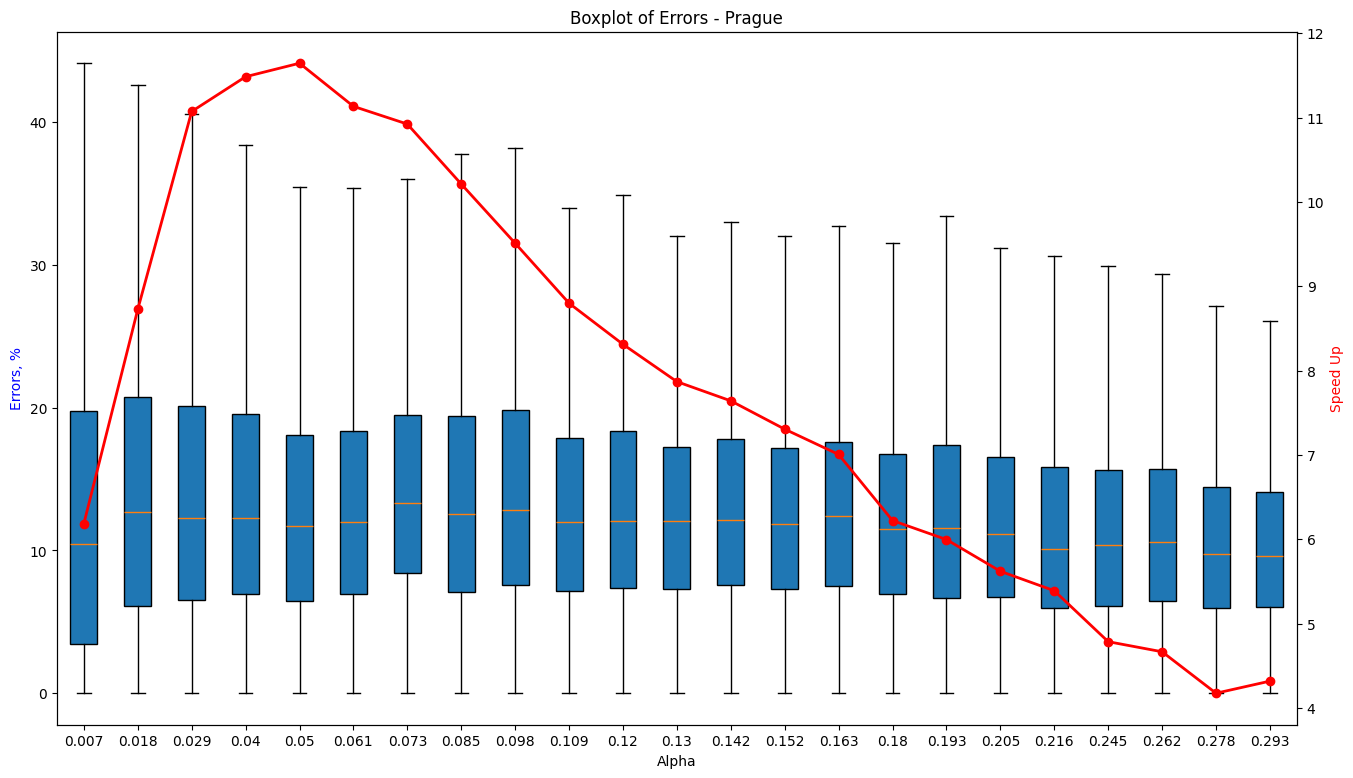

In [36]:
import matplotlib.pyplot as plt
import os
import pickle



def box_visualisation(absolute_errors, alphas, pfa_times, name='city', output_dir="data/img", show=False):
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Создаем boxplot на основной оси
    ax1.boxplot(absolute_errors, showfliers=False, vert=True, patch_artist=True)
    ax1.set_ylabel('Errors, %', color='b')
    ax1.set_xlabel('Alpha')
    ax1.set_title(f'Boxplot of Errors - {name}')
    ax1.set_xticks(range(1, len(alphas) + 1))
    ax1.set_xticklabels(alphas)

    # Создаем второстепенную ось для pfa time
    ax2 = ax1.twinx()
    ax2.plot(range(1, len(alphas) + 1), pfa_times, color='r', marker='o', linestyle='-', linewidth=2)
    ax2.set_ylabel('Speed Up', color='r')

    # Создание папки, если она не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Запись PNG
    file_path = os.path.join(output_dir, f"boxplot_errors_{name}.png")
    plt.savefig(file_path, dpi=200)
    
    print(f"Boxplot saved to {file_path}")
    if show:
        plt.show()


for n in ['ASHA', 'KRG', 'PARIS', 'Prague']:
    with open(f'clusters_results/2024_06_26/{n}.pkl', 'rb') as f:
        data = pickle.load(f)

        # Извлекаем значения absolute_err, alpha и pfa time в отдельные списки
        absolute_errors = [[i * 100 for i in results.errors] for results in data.points_results]
        alphas = [round(i.alpha, 3) for i in data.points_results]
        pfa_times = [i.speed_up[0] for i in data.points_results]

        # Вызываем функцию для создания и сохранения boxplot
        box_visualisation(absolute_errors, alphas, pfa_times, data.name, show=True)

In [33]:
data.points_results[0].speed_up[0]

0.7662197860527823

In [61]:
data.points_results[0].

#  'absolute_err'
#  'absolute_time'
#  'alpha'
#  'centroid_density'
#  'centroid_edges'
#  'centroid_nodes'
#  'errors'
#  'resolution'
#  'speed_up'
#  'time'

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'absolute_err',
 'absolute_time',
 'alpha',
 'centroid_density',
 'centroid_edges',
 'centroid_nodes',
 'errors',
 'resolution',
 'speed_up',
 'time']

In [2]:
import pickle
import pandas as pd
import numpy as np
for n in ['ASHA']:
    with open(f'clusters_results/2024_06_26/{n}.pkl', 'rb') as f:
        data = pickle.load(f)
    absolute_errors = [np.array([i * 100 for i in results.errors]).mean() for results in data.points_results]
    alphas = [round(i.alpha, 3) for i in data.points_results]
    pfa_times = [i.speed_up[0] for i in data.points_results]
df = pd.DataFrame([absolute_errors, alphas, pfa_times]).T
df.columns = ['error', 'alpha', 'speed_up']
df

,error,alpha,speed_up
0,3.771089,0.034,0.766220
1,3.173707,0.052,0.873412
2,7.558484,0.064,1.036243
3,7.840938,0.077,1.119833
4,7.257565,0.092,1.270069
5,8.921978,0.108,1.376309
6,6.386283,0.126,1.419966
7,6.953296,0.147,1.413017
8,5.879155,0.162,1.411289
9,8.615446,0.180,1.500780


In [6]:
import requests
import json
import pandas as pd
from tqdm import tqdm

def get_cities_with_population_greater_than_n(n):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
        [out:json];
        (
            relation["place"="city"];
            relation["place"="town"];
            relation["place"="village"];
        );
        out;
    """
    response = requests.get(overpass_url, params={"data": overpass_query})
    data = response.json()

    result = {
        'cities': [],
        'city_ids': [],
        'population_list': [],
        'place': []
    }

    for element in tqdm(data["elements"], leave=False):
        if "population" in element["tags"]:
            population = element["tags"]["population"].replace(" ", "")
            try:
                population = int(population)
                if population >= n:
                    if "name" in element["tags"]:
                        result['cities'].append(element['tags']['name'])  # Добавляем название города в список городов
                        result['city_ids'].append(element['id'])  # Добавляем идентификатор в список идентификаторов
                        result['population_list'].append(element["tags"]["population"].replace(" ", ""))
                        result['place'].append(element['tags']['place'])
            except ValueError:
                # Здесь можно добавить логирование или другую обработку ошибок
                print(f"Не удалось преобразовать население в число для {element['tags'].get('name', 'неизвестного города')}")
    
    return pd.DataFrame(result)  # Возвращаем оба списка    

if __name__ == "__main__":
    min_population = 30000  # Задайте минимальное население
    result = get_cities_with_population_greater_than_n(min_population)

Не удалось преобразовать население в число для San Bernardino
Не удалось преобразовать население в число для Newport
Не удалось преобразовать население в число для Moncton
Не удалось преобразовать население в число для Riverview
Не удалось преобразовать население в число для בני ברק
Не удалось преобразовать население в число для Barnstable
Не удалось преобразовать население в число для Edmonton
Не удалось преобразовать население в число для Myrtleford
Не удалось преобразовать население в число для Tukboy
Не удалось преобразовать население в число для طنجة
Не удалось преобразовать население в число для Fontana
Не удалось преобразовать население в число для Погорелое Городище
Не удалось преобразовать население в число для Belmopan
Не удалось преобразовать население в число для Ontario
Не удалось преобразовать население в число для Ma Gyi Phyu (မန်ကျည်းဖြူ)
Не удалось преобразовать население в число для Gardi Muladub
Не удалось преобразовать население в число для Benque Viejo del Carmen
Н

In [8]:
import os
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')

# Путь к папке с файлами CSV
folder_path = 'data\\csv_1'
files = [f for f in os.listdir(folder_path) if f.startswith('output_R') and f.endswith('.csv')]

# Чтение всех файлов CSV и объединение их в один DataFrame
data_frames = []
for file in files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df['R_number'] = file.split('_R')[1].split('.csv')[0]
    data_frames.append(df)

combined_df = pd.concat(data_frames, ignore_index=True)
combined_df['speed_up'] = combined_df['dijkstra_time'] / combined_df['times']

# Создание словаря для сопоставления city_ids с названием города
city_id_to_name = dict(zip(result['city_ids'], result['cities']))

# Функция для получения центра города по названию города
def get_city_center_by_name(city_name):
    try:
        gdf = ox.geocode_to_gdf(city_name)
        center = gdf.geometry.centroid.iloc[0]
        return gdf, center
    except Exception as e:
        print(f"Failed to get city center for city: {city_name}, error: {e}")
        return None, None

# Получение уникальных значений R_number
unique_r_numbers = combined_df['R_number'].unique()

# Скачивание данных и создание GeoDataFrame
city_data = []
for R_number in tqdm(unique_r_numbers):
    city_name = city_id_to_name.get(int(R_number))
    if city_name:
        place_name, center = get_city_center_by_name(city_name)
        if place_name is not None:
            city_data.append({
                'R_number': R_number,
                'name_city': city_name,
                'geometry': center
            })

city_gdf = gpd.GeoDataFrame(city_data)

100%|██████████| 756/756 [04:59<00:00,  2.52it/s]


In [9]:
city_gdf

,R_number,name_city,geometry
0,10089445,Копейск,POINT (61.63144 55.13385)
1,10092921,Olmaliq,POINT (69.59787 40.84888)
2,10185071,Магнитогорск,POINT (59.02975 53.40837)
3,10221652,Октябрьский,POINT (53.48886 54.49580)
4,10268812,Brantford,POINT (-80.27227 43.15564)
...,...,...,...
751,9691188,רמלה,POINT (34.87192 31.92572)
752,9701440,Баксан,POINT (43.59903 43.67625)
753,9942898,Pacifica,POINT (-122.47814 37.61142)
754,9958566,شهر خمین,POINT (50.08316 33.63429)


In [38]:
combined_df

,error,time_centr,times,alpha,dijkstra_time,R_number,speed_up
0,2.408896,0.543499,12.003601,0.011,10.506312,10089445,0.875263
1,2.601728,0.457626,11.130596,0.014,10.506312,10089445,0.943913
2,7.551250,0.291848,8.531677,0.022,10.506312,10089445,1.231447
3,5.011558,0.210539,6.337589,0.045,10.506312,10089445,1.657777
4,6.868845,0.206141,5.299418,0.070,10.506312,10089445,1.982541
...,...,...,...,...,...,...,...
6607,11.824568,0.135997,3.626847,0.089,7.436029,9986400,2.050274
6608,13.653888,0.158015,3.295653,0.151,7.436029,9986400,2.256314
6609,12.516316,0.188121,3.310578,0.252,7.436029,9986400,2.246142
6610,12.271537,0.257031,3.896620,0.418,7.436029,9986400,1.908328


In [41]:
# filtered_df = combined_df[combined_df['error'] <= 10]
# min_time_df = combined_df.loc[combined_df.groupby('R_number')['times'].idxmin()]
max_speed_up_df = combined_df.loc[combined_df.groupby('R_number')['speed_up'].idxmax()]
final_gdf = max_speed_up_df.merge(city_gdf, on='R_number')
final_gdf = gpd.GeoDataFrame(final_gdf, geometry='geometry', crs='EPSG:4326')

In [42]:
final_gdf

,error,time_centr,times,alpha,dijkstra_time,R_number,speed_up,name_city,geometry
0,14.617435,0.324186,4.389577,0.215,10.506312,10089445,2.393468,Копейск,POINT (61.63144 55.13385)
1,19.344819,0.105292,2.468152,0.166,4.726512,10092921,1.915001,Olmaliq,POINT (69.59787 40.84888)
2,7.969270,1.268157,6.607126,0.140,27.581901,10185071,4.174569,Магнитогорск,POINT (59.02975 53.40837)
3,17.749136,0.179020,3.663249,0.152,8.560773,10221652,2.336935,Октябрьский,POINT (53.48886 54.49580)
4,14.563166,0.805555,5.130922,0.168,18.593547,10268812,3.623822,Brantford,POINT (-80.27227 43.15564)
...,...,...,...,...,...,...,...,...,...
751,13.918237,0.147410,2.493216,0.181,5.477116,9691188,2.196808,רמלה,POINT (34.87192 31.92572)
752,12.046287,0.046777,0.265228,0.249,0.422273,9701440,1.592114,Баксан,POINT (43.59903 43.67625)
753,8.436869,0.133417,2.689897,0.256,5.022122,9942898,1.867031,Pacifica,POINT (-122.47814 37.61142)
754,23.671841,0.672021,5.181300,0.109,18.472492,9958566,3.565224,شهر خمین,POINT (50.08316 33.63429)


In [45]:
from sklearn.preprocessing import MinMaxScaler
# mask = final_gdf['speed_up'] > 0
scaler = MinMaxScaler(feature_range=(2, 4))  # Устанавливаем диапазон радиусов
final_gdf["size"] = scaler.fit_transform(final_gdf[["error"]])

final_gdf.explore(tiles='CartoDB dark_matter',column='error', cmap='RdYlGn_r', scheme='fisherjenks', k=10, style_kwds={"style_function": lambda x: {"radius": x["properties"]["size"]}}
)

In [43]:
final_gdf.to_file('final_gdf.geojson')

In [52]:
import pandas as pd
import networkx as nx

# Функция для загрузки графа из файлов формата graphml
def load_graph(graph_filename):
    return nx.read_graphml(graph_filename)

# Проход по строкам GeoDataFrame final_gdf
for index, row in final_gdf.iterrows():
    # Получаем номер R из столбца 'R_number'
    R_number = int(row['R_number'])
    
    # Формируем путь к файлу графа
    graph_filename = f'data/graphs_1/graph_R{R_number}.graphml'
    
    # Загружаем граф из файла
    G = load_graph(graph_filename)
    
    # Добавляем количество узлов в новый столбец 'nodes' в DataFrame
    final_gdf.loc[index, 'nodes'] = G.number_of_nodes()

# Выводим обновленный GeoDataFrame final_gdf
final_gdf

,error,time_centr,times,alpha,dijkstra_time,R_number,speed_up,name_city,geometry,size,nodes
0,14.617435,0.324186,4.389577,0.215,10.506312,10089445,2.393468,Копейск,POINT (61.63144 55.13385),2.633399,1476.0
1,19.344819,0.105292,2.468152,0.166,4.726512,10092921,1.915001,Olmaliq,POINT (69.59787 40.84888),2.846482,827.0
2,7.969270,1.268157,6.607126,0.140,27.581901,10185071,4.174569,Магнитогорск,POINT (59.02975 53.40837),2.333739,3327.0
3,17.749136,0.179020,3.663249,0.152,8.560773,10221652,2.336935,Октябрьский,POINT (53.48886 54.49580),2.774558,1172.0
4,14.563166,0.805555,5.130922,0.168,18.593547,10268812,3.623822,Brantford,POINT (-80.27227 43.15564),2.630953,2319.0
...,...,...,...,...,...,...,...,...,...,...,...
751,13.918237,0.147410,2.493216,0.181,5.477116,9691188,2.196808,רמלה,POINT (34.87192 31.92572),2.601884,980.0
752,12.046287,0.046777,0.265228,0.249,0.422273,9701440,1.592114,Баксан,POINT (43.59903 43.67625),2.517507,385.0
753,8.436869,0.133417,2.689897,0.256,5.022122,9942898,1.867031,Pacifica,POINT (-122.47814 37.61142),2.354815,931.0
754,23.671841,0.672021,5.181300,0.109,18.472492,9958566,3.565224,شهر خمین,POINT (50.08316 33.63429),3.041519,2302.0


In [53]:
final_gdf['k'] = final_gdf['nodes'] / (final_gdf['alpha'] * final_gdf['nodes'])
final_gdf

,error,time_centr,times,alpha,dijkstra_time,R_number,speed_up,name_city,geometry,size,nodes,k
0,14.617435,0.324186,4.389577,0.215,10.506312,10089445,2.393468,Копейск,POINT (61.63144 55.13385),2.633399,1476.0,4.651163
1,19.344819,0.105292,2.468152,0.166,4.726512,10092921,1.915001,Olmaliq,POINT (69.59787 40.84888),2.846482,827.0,6.024096
2,7.969270,1.268157,6.607126,0.140,27.581901,10185071,4.174569,Магнитогорск,POINT (59.02975 53.40837),2.333739,3327.0,7.142857
3,17.749136,0.179020,3.663249,0.152,8.560773,10221652,2.336935,Октябрьский,POINT (53.48886 54.49580),2.774558,1172.0,6.578947
4,14.563166,0.805555,5.130922,0.168,18.593547,10268812,3.623822,Brantford,POINT (-80.27227 43.15564),2.630953,2319.0,5.952381
...,...,...,...,...,...,...,...,...,...,...,...,...
751,13.918237,0.147410,2.493216,0.181,5.477116,9691188,2.196808,רמלה,POINT (34.87192 31.92572),2.601884,980.0,5.524862
752,12.046287,0.046777,0.265228,0.249,0.422273,9701440,1.592114,Баксан,POINT (43.59903 43.67625),2.517507,385.0,4.016064
753,8.436869,0.133417,2.689897,0.256,5.022122,9942898,1.867031,Pacifica,POINT (-122.47814 37.61142),2.354815,931.0,3.906250
754,23.671841,0.672021,5.181300,0.109,18.472492,9958566,3.565224,شهر خمین,POINT (50.08316 33.63429),3.041519,2302.0,9.174312


<Axes: xlabel='k', ylabel='speed_up'>

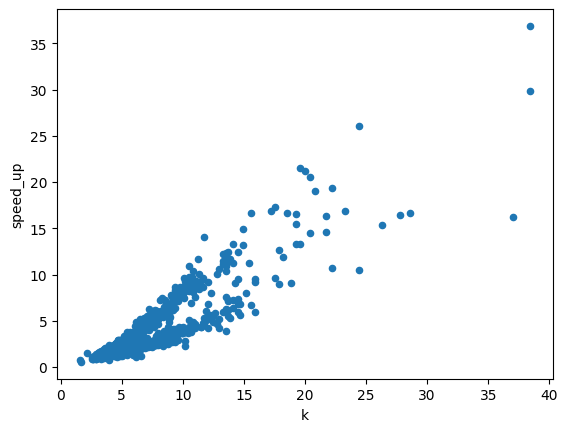

In [55]:
from mpl_toolkits.mplot3d import Axes3D
final_gdf.plot(kind='scatter', x='k', y='speed_up')


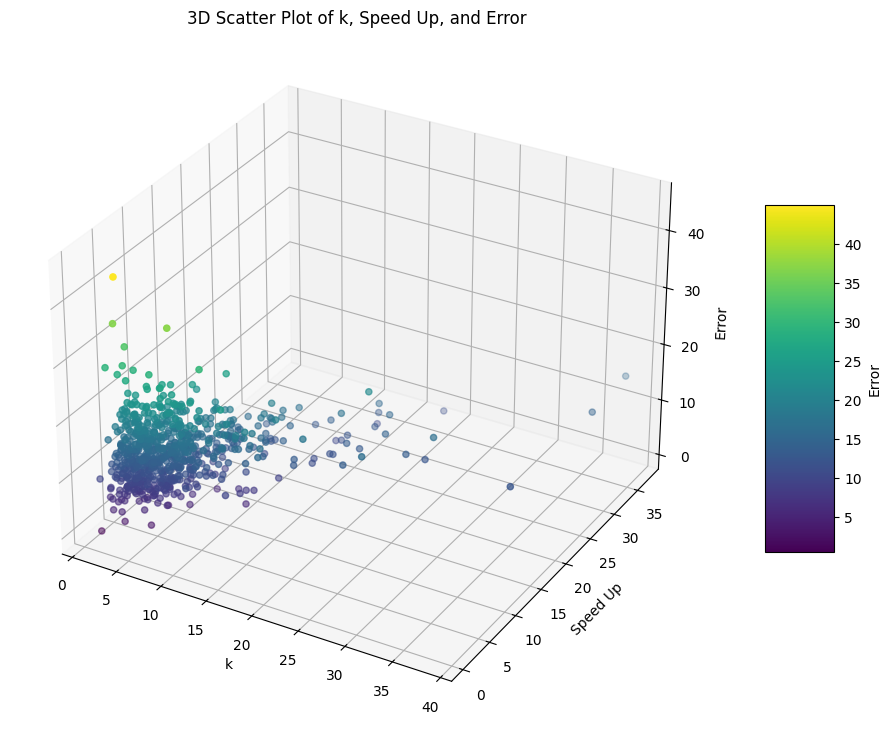

In [59]:
import plotly.express as px

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')

# Использование данных для осей x, y и z
x = final_gdf['k']
y = final_gdf['speed_up']
z = final_gdf['error']

# Создание scatter plot
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

# Добавление цветовой шкалы
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Error')

# Настройка меток осей
ax.set_xlabel('k')
ax.set_ylabel('Speed Up')
ax.set_zlabel('Error')
ax.set_title('3D Scatter Plot of k, Speed Up, and Error')

plt.show()


In [62]:
# Создание 3D scatter plot с использованием plotly
fig = px.scatter_3d(
    final_gdf,
    x='k',
    y='speed_up',
    z='error',
    color='error',  # Цвет точек в зависимости от значения 'error'
    title='3D Scatter Plot of k, Speed Up, and Error',
    labels={'k': 'k', 'speed_up': 'Speed Up', 'error': 'Error'}
)

# Отображение графика
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

<Axes: ylabel='Frequency'>

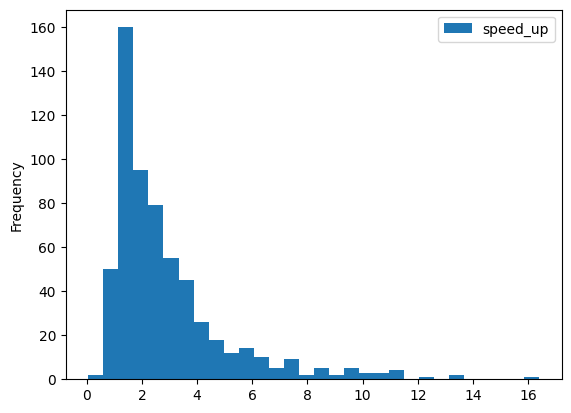

In [79]:
final_gdf[final_gdf.speed_up < 20].plot(kind='hist', y='speed_up',bins=30)